In this notebook, we ensemble 6 different VGG-16 models. Each model has its own strengths has weaknesses. Eg: Some models do better with class 1, and some do better in class 4 (our dataset has 6 classes). Thus, we ensemble the models to get an overall better confusion matrix that works well for all the classes, to make sure no class is underrepresented or classified badly. 

Let us now import all required header files. We will need to run this code in a clean Python/Anaconda/Miniconda environment, to make sure there are no conflicts. This code works the best with a configured GPU. Our code was developed and testing with a gaming GPU, RTX 2060 with 6GB VRAM. You will need Numpy, Scipy, SKLearn, Pandas, Matplotlib, Tensroflow 2.0, Keras and basic Math/OS libraries to run this program. 

In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
    print("GPU device-name is:", device_name)
print('Found GPU at: {}'.format(device_name))
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
import math 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Data Visualizations
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

GPU device-name is: /device:GPU:0
Found GPU at: /device:GPU:0


Let us import the dataset. 

In [2]:
train_ds = np.load('train.npz')

Resize as required. 

In [3]:
x = train_ds['arr_0']
y = train_ds['arr_1']

x = x.reshape(1500,28,28,1)
print(y.shape)

(1500,)


In [4]:
train_images = x 

In [5]:
train_labels = y

The code below resizes the image to 80 x 80. The default size of (28, 28, 1) does not work for a VGG-16 input, as it is trained for higher dimensional data. Hence, we need the code below. Let us preprocess the image and add 3 channels (since the transfer learning model we use, VGG-16, requires 3 channels to be present.

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def change_size(image):
    img = array_to_img(image, scale=False) #returns PIL Image
    img = img.resize((80, 80)) #resize image
    img = img.convert(mode='RGB') #makes 3 channels
    arr = img_to_array(img) #convert back to array
    return arr.astype(np.float64)

Apply the above to our training data. Then convert the training labels to OneHot Encoding, using the to_cateogorical API. 

In [7]:
train_arr_75 = [change_size(img) for img in x]
del x
train_arr_75 = np.array(train_arr_75)
train_arr_75.shape
y = to_categorical(y)

Now, we need to set up ImageDataGenerator for generating different models for different classes. There are some ImageDataGenerator Configurations that perform better for a particular class, and some that perform worse. 

Also, we needed to apply VGG-16's Preprocess Input API to get the input to the right format. 

samplewise_std_normalization = True -> Better Confusion Matrix for Class 4 
zca_whitening = True -> Better Confusion Matrix for Class 1. 

If both the above booleans are set to False, then the overall confusion matrix is more balanced across all classes, with Class 1 and Class 4 being the weakest. 

In [8]:
train_arr_75 = preprocess_input(train_arr_75)
train_arr_75 = np.array(train_arr_75)
train_arr_75 = train_arr_75.astype('float32')
train_arr_75 /= 255

train_images, test_images, train_labels, test_labels = train_test_split(train_arr_75,y, test_size=0.1, random_state=1, stratify=y)

#Model1
image_gen1 = ImageDataGenerator(
    #samplewise_center=True, don't
    #featurewise_center=True, don't
    #featurewise_std_normalization=True, don't
    #samplewise_std_normalization = True,# accuracy -0.83, better confusion on class4
    #zca_whitening = True,
        zoom_range=0.2, # randomly zoom into images
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        #20 - 0.836
        width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
        #0.1-  0.823, 0.4 - 0.73, 0.3-0.86
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        #0.3-0.77
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

train_generator = image_gen1.flow(train_images, 
                                 train_labels,
                                batch_size=32,
                                shuffle=True,
                                seed=42)
valid_generator = image_gen1.flow(test_images,
                                 test_labels,
                                batch_size=16,
                                shuffle=True)

Let us define Kaiming Initializer for weights. Reference: https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79

In [9]:
import math 
def kaiming(shape, dtype=None):
    return tf.random.normal(shape, dtype=dtype)*math.sqrt(2./shape[0])

Let us define our VGG model.

In [10]:
import tensorflow.keras as keras
model = Sequential()
model = VGG16(weights = "imagenet",include_top=False, input_shape=(80, 80, 3))
flat1 = Flatten()(model.layers[-1].output)
x2 = Dropout(.2)(flat1)
class1 = Dense(1024, activation='relu', kernel_initializer= kaiming)(x2)
#class1 = Dense(2**(j + 4), activation='relu')(x2)
x2 = Dropout(.3)(class1)
output = Dense(6, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)
model.compile(optimizer=keras.optimizers.Adamax(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0     

Let us Freeze the layers till Block 3 with the default ImageNet weights. VGG-16 is trained on ImageNet by default. 

In [12]:
for layer in model.layers:
    if layer.name == "block3_pool":
        break
    layer.trainable = False

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()
history = model.fit(train_generator, validation_data=valid_generator, epochs=4, 
          steps_per_epoch=train_generator.n//train_generator.batch_size,
         validation_steps=valid_generator.n//valid_generator.batch_size)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 42 steps, validate for 9 steps
Epoch 1/4
42/42 [==============================] - 9s 226ms/step - loss: 1.3991 - accuracy: 0.4461 - val_loss: 0.9441 - val_accuracy: 0.6111
Epoch 2/4
42/42 [==============================] - 3s 78ms/step - loss: 0.9417 - accuracy: 0.6608 - val_loss: 0.7634 - val_accuracy: 0.7917
Epoch 3/4
42/42 [==============================] - 3s 78ms/step - loss: 0.7503 - accuracy: 0.7307 - val_loss: 0.6241 - val_accuracy: 0.7708
Epoch 4/4
42/42 [==============================] - 3s 78ms/step - loss: 0.6492 - accuracy: 0.7663 - val_loss: 0.6261 - val_accuracy: 0.7986


(The above run is just a sample model execution. In reality, we needed to run the model many times to get a result with good validation loss and validation accuracies)

Let us print the Confusion Matrix of the model above. To get an idea of how it looks like. We do something similar many times, and accordingly get our 5 different weights. Which are then ensembled. Since CNN has randomness/entropy, it often takes many different tests to get a good enough model. 

Accuracy Score is displayed below:
0.8466666666666667


array([[18,  5,  0,  2,  0,  0],
       [ 1, 22,  0,  0,  0,  2],
       [ 0,  0, 25,  0,  0,  0],
       [ 0,  0,  0, 24,  0,  1],
       [ 0,  4,  0,  2, 14,  5],
       [ 0,  1,  0,  0,  0, 24]], dtype=int64)

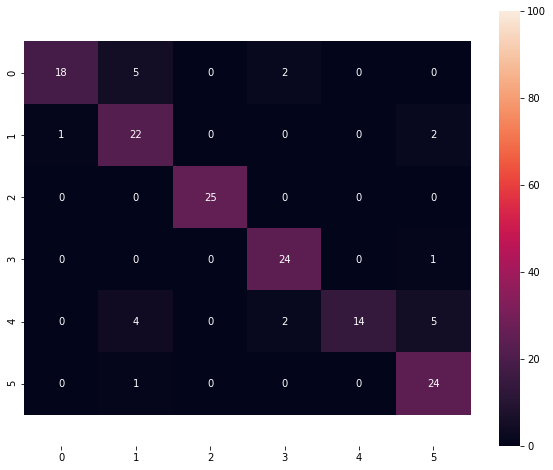

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

Y_val_pred = model.predict(test_images)#, num_of_test_samples // batch_size+1
Y_val_pred = np.argmax(Y_val_pred, axis=1)

test_labels = np.argmax(test_labels, axis = 1)

cf_matrix = confusion_matrix(test_labels, Y_val_pred)
print("Accuracy Score is displayed below:")

print(accuracy_score(test_labels, Y_val_pred))
categories = list(np.unique(test_labels))
df_cm = pd.DataFrame(cf_matrix,index = categories,
  columns = categories)
plt.figure(figsize=(10,8))
res = sns.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0)
bottom, top = res.get_ylim()
res.set_ylim(bottom + 0.5, top - 0.5)
cf_matrix

In [15]:
#Let us go over how we save a weight.


#Uncomment the line below to save that weight
#model.save_weights("80x80badClass4.hdf5")

Basically, we had repeated the above steps many times till we got a good set of weights. We then saved them, and proceeded forward to do a probabilistic voting. 

We will see how ensembling or soft voting is carried out. 

First, create 5 dummy models.

In [16]:
model5 = Sequential()
input_tensor = Input(shape=(80, 80, 3))
model5 = VGG16(weights = "imagenet",include_top=False, input_shape=(80, 80, 3))
#model = ResNet18(input_shape=(224,224,3), weights='imagenet', classes=1000)
# add new classifier layers
flat1 = Flatten()(model5.layers[-1].output)
x2 = Dropout(.2)(flat1)
class1 = Dense(1024, activation='relu', kernel_initializer= kaiming)(x2)
x2 = Dropout(.3)(class1)
output = Dense(6, activation='softmax')(class1)
model5 = Model(inputs=model5.inputs, outputs=output)
model5.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#Do not use default learning rate since it is too high!

In [17]:
model = Sequential()
input_tensor = Input(shape=(75, 75, 3))
model = VGG16(weights = "imagenet",include_top=False, input_shape=(80, 80, 3))
#model = ResNet18(input_shape=(224,224,3), weights='imagenet', classes=1000)
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
x2 = Dropout(.2)(flat1)
class1 = Dense(1024, activation='relu', kernel_initializer= kaiming)(x2)
x2 = Dropout(.3)(class1)
output = Dense(6, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#Do not use default learning rate since it is too high!

In [18]:
model2 = Sequential()
input_tensor = Input(shape=(75, 75, 3))
model2 = VGG16(weights = "imagenet",include_top=False, input_shape=(80, 80, 3))
#model = ResNet18(input_shape=(224,224,3), weights='imagenet', classes=1000)
# add new classifier layers
flat1 = Flatten()(model2.layers[-1].output)
x2 = Dropout(.2)(flat1)
class1 = Dense(1024, activation='relu', kernel_initializer= kaiming)(x2)
x2 = Dropout(.3)(class1)
output = Dense(6, activation='softmax')(class1)
model2 = Model(inputs=model2.inputs, outputs=output)
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#Do not use default learning rate since it is too high!

In [19]:
model6 = Sequential()
input_tensor = Input(shape=(80, 80, 3))
model6 = VGG16(weights = "imagenet",include_top=False, input_shape=(80, 80, 3))
#model = ResNet18(input_shape=(224,224,3), weights='imagenet', classes=1000)
# add new classifier layers
flat1 = Flatten()(model6.layers[-1].output)
x2 = Dropout(.2)(flat1)
class1 = Dense(1024, activation='relu', kernel_initializer= kaiming)(x2)
x2 = Dropout(.3)(class1)
output = Dense(6, activation='softmax')(class1)
model6 = Model(inputs=model6.inputs, outputs=output)
model6.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#Do not use default learning rate since it is too high!

In [20]:
model7 = Sequential()
input_tensor = Input(shape=(80, 80, 3))
model7 = VGG16(weights = "imagenet",include_top=False, input_shape=(80, 80, 3))
#model = ResNet18(input_shape=(224,224,3), weights='imagenet', classes=1000)
# add new classifier layers
flat1 = Flatten()(model7.layers[-1].output)
x2 = Dropout(.2)(flat1)
class1 = Dense(1024, activation='relu', kernel_initializer= kaiming)(x2)
x2 = Dropout(.3)(class1)
output = Dense(6, activation='softmax')(class1)
model7 = Model(inputs=model7.inputs, outputs=output)
model7.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model5.load_weights('badC2.hdf5')

In [22]:
model6.load_weights('badC490_1.hdf5')

In [23]:
model7.load_weights('badC490.hdf5')

In [24]:
model.load_weights('badC285ButGoodC4.hdf5')

In [25]:
model2.load_weights('badC4ButGoodBalance90.hdf5')

Let us load the test dataset below. This is to be used for final predictions and generating the CSV file. 

In [26]:
test_ds = np.load('test.npz')

Let us replace the last layer of model5 (the SoftMax Activation Function Layer) with an SVM. This SVM predicts on Features extracted by the VGG. This worked the best for our case. 

We are printing the shapes of various stages of the CNN + SVM operation below. 

In [27]:
model5.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0   

In [28]:
#Since we had done an argmax earlier, we now need to restore the original values. This is NOT random, as we have hardcoded a random state/random seed,

train_images, test_images, train_labels, test_labels = train_test_split(train_arr_75,y, test_size=0.1, random_state=1, stratify=y)

In [30]:
model5.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0   

In [31]:
model_featlast = Model(inputs=model5.input,outputs=model5.get_layer('dense_2').output)

feat_trainlast = model_featlast.predict(train_images)
print(feat_trainlast.shape)

feat_vallast = model_featlast.predict(test_images)
print(feat_vallast.shape)

feat_trainlast = model_featlast.predict(train_images)
print(feat_trainlast.shape)

(1350, 1024)
(150, 1024)
(1350, 1024)


In [32]:
from sklearn.svm import SVC

svm3l = SVC(kernel='rbf', probability = True)

svm3l.fit(feat_trainlast,np.argmax(train_labels,axis=1))
svm3l.score(feat_trainlast,np.argmax(train_labels,axis=1))
val_scorel = svm3l.score(feat_vallast,np.argmax(test_labels,axis=1))
val_scorel

0.9066666666666666

Accuracy Score is displayed below:
0.94


array([[23,  1,  0,  1,  0,  0],
       [ 0, 24,  0,  0,  1,  0],
       [ 0,  0, 25,  0,  0,  0],
       [ 0,  0,  0, 24,  0,  1],
       [ 0,  0,  0,  2, 22,  1],
       [ 0,  0,  0,  0,  2, 23]], dtype=int64)

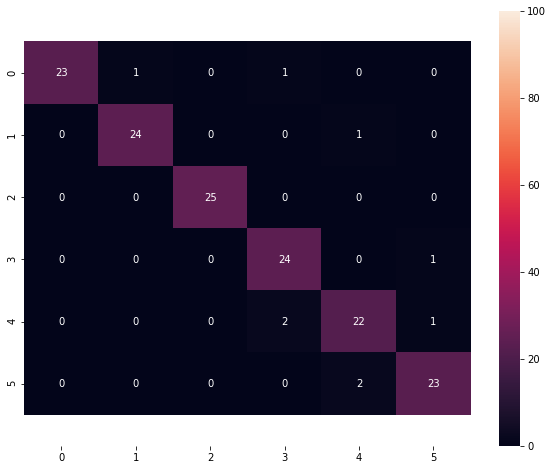

In [33]:
results = np.zeros( (test_images.shape[0],6) ) 

#SVM for L5
feat_val_2 = model_featlast.predict(test_images)
Pred_labels_1 = svm3l.predict_proba(feat_val_2)
results = results + Pred_labels_1
results = results + model.predict(test_images)
results = results + model2.predict(test_images)
results = results + model6.predict(test_images)
results = results + model7.predict(test_images)
#results = results + model7.predict(test_images)
results = np.argmax(results,axis = 1)
Y_val_pred = results


test_labels = np.argmax(test_labels, axis = 1)
cf_matrix = confusion_matrix(test_labels, Y_val_pred)
print("Accuracy Score is displayed below:")

print(accuracy_score(test_labels, Y_val_pred))
categories = list(np.unique(test_labels))
df_cm = pd.DataFrame(cf_matrix,index = categories,
  columns = categories)
plt.figure(figsize=(10,8))
res = sns.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0)
bottom, top = res.get_ylim()
res.set_ylim(bottom + 0.5, top - 0.5)
cf_matrix

Using the above weights, we have generated our confusion matrix of 94% accuracy, and a balanced prediction across all the classes. 

In [34]:
y2 = test_ds['arr_0']
y2 = y2.reshape(60000,28,28,1)

In [35]:
y2 = np.array([change_size(img) for img in y2])

In [36]:
y2.shape

(60000, 80, 80, 3)

In [37]:
#To save RAM
y2 = np.float32(y2)

In [38]:
y2 = preprocess_input(y2)

In [39]:
y2 = np.array(y2)

In [40]:
y2 = y2.astype('float32')

In [41]:
y2 /= 255

In [42]:
results = np.zeros( (y2.shape[0],6) ) 

In [43]:
results = results + model.predict(y2)

In [44]:
results = results + model2.predict(y2)

In [45]:
results = results + model6.predict(y2)

In [46]:
results = results + model7.predict(y2)

In [47]:
#Model 5 - SVM + VGG
feat_val_1 = model_featlast.predict(y2)
Pred_labels_1 = svm3l.predict_proba(feat_val_1)

results = results + Pred_labels_1

In [48]:
results = np.argmax(results,axis = 1)

In [49]:
results

array([2, 2, 4, ..., 5, 2, 4], dtype=int64)

In [50]:
import pandas as pd
t_dataframe=pd.DataFrame(results, columns=['Category'])

In [51]:
t_dataframe["Id"] = t_dataframe.index

In [52]:
columns_titles = ["Id","Category"]
t_dataframe=t_dataframe.reindex(columns=columns_titles)

In [53]:
#Save the CSV!

t_dataframe.to_csv("answerCSV.csv", index = False)

And thus, we have generated our CSV. This can be submitted to Kaggle to reproduce our accuracy.